In [1]:
from fastai.vision import *

## Pixel Similarity

A straightforward approach might be to find an 'average' for each number.  Each of these 'averages' can then be compared with an unseen number and we can predict that the unseen number will be the one that it is most similar to.  We can use the training data to calculate the averages.  To determine the similarity we could compare each pixel and sum the differences to find a similarity value and simply selecting the number with the smallest value to be our prediction.

#### Let's explore the dataset

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path.ls()

[PosixPath('/home/calum/.fastai/data/mnist_png/training'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing'),
 PosixPath('/home/calum/.fastai/data/mnist_png/models')]

In [17]:
train = (path/'testing')
train.ls()

[PosixPath('/home/calum/.fastai/data/mnist_png/testing/3'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/5'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/4'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/6'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/2'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/0'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/7'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/8'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/1'),
 PosixPath('/home/calum/.fastai/data/mnist_png/testing/9')]

In [11]:
ones = (train/'9').ls()
len(ones)

5949

#### Open an example 1

torch.Size([1, 28, 28])

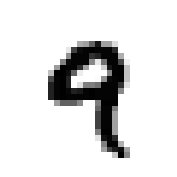

In [12]:
img = ones[0]
img = open_image(img, convert_mode='L') # mode is only 1 channel (i.e. is greyscale)
img.show(cmap='binary') # shows image in greyscale
img.shape

In [13]:
# This is just to demonstrate each image is made up of pixels with values from 0 to 1\
df = pd.DataFrame(image2np(img.data)[3:25,3:24])
df.style.set_properties(**{'font-size':'4pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.329412,0.376471,0.607843,0.913725,0.376471,0.376471,0.141176,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.094118,0.745098,0.956863,0.984314,0.992157,0.984314,0.984314,0.984314,0.831373,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.439216,0.984314,0.984314,0.984314,0.803922,0.862745,0.984314,0.984314,0.984314,0.313726,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.486275,0.956863,0.984314,0.984314,0.984314,0.466667,0.090196,0.552941,0.984314,0.984314,0.713726,0.062745,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.392157,0.992157,0.984314,0.984314,0.827451,0.368627,0.000000,0.000000,0.188235,0.909804,0.984314,0.992157,0.243137,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.250980,0.992157,1.000000,0.945098,0.619608,0.074510,0.000000,0.000000,0.000000,0.000000,0.486275,0.992157,1.000000,0.247059,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.713726,0.984314,0.992157,0.862745,0.000000,0.000000,0.000000,0.000000,0.015686,0.439216,0.956863,0.984314,0.992157,0.243137,0.000000,0.000000,0.000000


#### Calculate an average
These averaged digits are called <u>centroids</u> and are calculated by stacking all examples of a digit on top of one another, then taking the average value for each pixel

In [14]:
one_tensors = [open_image(o, convert_mode='L').data for o in ones]
len(one_tensors)

5949

In [15]:
stacked_ones = torch.stack(one_tensors)
stacked_ones.shape

torch.Size([5949, 1, 28, 28])

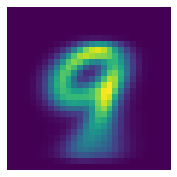

In [16]:
avg = stacked_ones.mean(0)
Image(avg).show()

This is the centroid for the digit 1, the average 1 in our data set.  